In [1]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import simps
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def load_N_data(path):
    import h5py
    
    ruta_archivo = path
    archivo_hdf5 = h5py.File(ruta_archivo, 'r')

    # Grupo
    refinement = archivo_hdf5['refinement_1']
    # Numero de datos
    return len(list(refinement.keys())) - 3 

def readh5(path, index):
    import h5py
    
    ruta_archivo = path
    archivo_hdf5 = h5py.File(ruta_archivo, 'r')

    # Grupo
    refinement = archivo_hdf5['refinement_1']
    # Numero de datos
    N_data = len(list(refinement.keys())) - 3 

    #print('N_data = ', N_data)

    # Conjunto de datos
    X = np.array(refinement["Xcoord"][:])
    Y = np.array(refinement["Ycoord"][:])
    Z = np.array(refinement["Zcoord"][:])

    xmin = X[0,0,0]
    xmax = X[0,0,-1]
    dx = X[0,0,1] - X[0,0,0]

    N = len(X[0,0,:])

    center = (N // 2, N // 2, N // 2)

    name = "rho_"+str(index)
    rho = np.array(refinement[name][:])
    # Calcula las diferencias para mover el máximo al centro
    max_index = np.unravel_index(np.argmax(rho), rho.shape)
    shifts = [c - m for c, m in zip(center, max_index)]
    # Aplica el desplazamiento a la matriz rho
    rho = np.roll(rho, shifts, axis=(0, 1, 2))

    x = np.linspace(xmin, xmax, N)
    y = np.linspace(xmin, xmax, N)
    z = np.linspace(xmin, xmax, N)

        
    archivo_hdf5.close()

    return x, y, z, rho

def readh5_2(path, index):
    import h5py
    
    ruta_archivo = path
    archivo_hdf5 = h5py.File(ruta_archivo, 'r')

    # Grupo
    refinement = archivo_hdf5['refinement_1']
    # Numero de datos
    N_data = len(list(refinement.keys())) - 3 

    #print('N_data = ', N_data)

    # Conjunto de datos
    X = np.array(refinement["Xcoord"][:])
    Y = np.array(refinement["Ycoord"][:])
    Z = np.array(refinement["Zcoord"][:])

    xmin = X[0,0,0]
    xmax = X[0,0,-1]
    dx = X[0,0,1] - X[0,0,0]

    N = len(X[0,0,:])

    center = (N // 2, N // 2, N // 2)

    name = "rho_"+str(index)
    rho = np.array(refinement[name][:])
    # # Calcula las diferencias para mover el máximo al centro
    # max_index = np.unravel_index(np.argmax(rho), rho.shape)
    # shifts = [c - m for c, m in zip(center, max_index)]
    # # Aplica el desplazamiento a la matriz rho
    # rho = np.roll(rho, shifts, axis=(0, 1, 2))

    x = np.linspace(xmin, xmax, N)
    y = np.linspace(xmin, xmax, N)
    z = np.linspace(xmin, xmax, N)

        
    archivo_hdf5.close()

    return x, y, z, rho


def interpolar_a_coordenadas_esfericas(x, y, z, rho):
    # Convertir coordenadas cartesianas a esféricas en cada punto de la malla
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / np.maximum(r, 1.0e-12))  # Ángulo polar
    phi = np.arctan2(y, x)     # Ángulo azimutal

    # Definir las dimensiones de la malla esférica
    Nr = 500
    Nt = 80
    Np = 160

    # Crear malla de puntos en coordenadas esféricas para evaluar la interpolación
    r_new = np.linspace(0.0, np.max(r), Nr)
    theta_new = np.linspace(0.0, np.pi, Nt)
    phi_new = np.linspace(0.0, 2.0 * np.pi, Np)
    R, Theta, Phi = np.meshgrid(r_new, theta_new, phi_new, indexing='ij')

    # Convertir coordenadas esféricas a cartesianas para evaluar el interpolador
    x_new = R * np.sin(Theta) * np.cos(Phi)
    y_new = R * np.sin(Theta) * np.sin(Phi)
    z_new = R * np.cos(Theta)

    # Crear interpolador
    interpolator = RegularGridInterpolator((x, y, z), rho, method='linear', bounds_error=False, fill_value=None)

    # Crear matriz de puntos a interpolar
    points = np.stack([x_new.flatten(), y_new.flatten(), z_new.flatten()], axis=-1)

    # Evaluar interpolador en los nuevos puntos
    rho_interp_flat = interpolator(points)
    rho_interp = rho_interp_flat.reshape((Nr, Nt, Np)) * np.sin(Theta)

     # Integración sobre phi y theta
    dTheta =  theta_new[1] - theta_new[0]
    dPhi = phi_new[1] - phi_new[0]

    rho_avg = rho_interp[:, :Nt-1, :Np-1] + rho_interp[:, 1:Nt, :Np-1] + rho_interp[:, 1:Nt, 1:Np] + rho_interp[:, :Nt-1, 1:Np]

    # Calcular la media y multiplicar por el diferencial de ángulo
    rho_avg = 0.25 * np.sum(rho_avg, axis=(1, 2)) * dTheta * dPhi / (4.0 * np.pi)

    return r_new, rho_avg


def core(r,rc):
    rhoc = (1.30569/rc)**4
    return rhoc * (1.0 + 0.091 * (r/rc)**2)**(-8)


In [2]:
N_data = load_N_data(path='/media/ivan/TOSHIBA EXT/TENA/g00/rho.h5')
t = np.linspace(0.0, 250.0, N_data)

In [3]:
#
# ----------------> g = -0.1
#
x, y, z, rho_0 = readh5_2(path = '/media/ivan/TOSHIBA EXT/TENA/g01/rho.h5', index=0)
x, y, z = np.meshgrid(x, y, z, indexing='ij')
# Encuentra el índice correspondiente a z=0
z_index = np.argmin(np.abs(z[0, 0, :]))
# Extrae la sección rho en z=0
rho_g00_0 = rho_0[z_index, :, :]


x, y, z, rho_0 = readh5_2(path = '/media/ivan/TOSHIBA EXT/TENA/g01/rho.h5', index=20)
x, y, z = np.meshgrid(x, y, z, indexing='ij')
# Encuentra el índice correspondiente a z=0
z_index = np.argmin(np.abs(z[0, 0, :]))
# Extrae la sección rho en z=0
rho_g00_1 = rho_0[z_index, :, :]

x, y, z, rho_0 = readh5_2(path = '/media/ivan/TOSHIBA EXT/TENA/g01/rho.h5', index=27)
x, y, z = np.meshgrid(x, y, z, indexing='ij')
# Encuentra el índice correspondiente a z=0
z_index = np.argmin(np.abs(z[0, 0, :]))
# Extrae la sección rho en z=0
rho_g00_2 = rho_0[z_index, :, :]

x, y, z, rho_0 = readh5_2(path = '/media/ivan/TOSHIBA EXT/TENA/g01/rho.h5', index=45)
x, y, z = np.meshgrid(x, y, z, indexing='ij')
# Encuentra el índice correspondiente a z=0
z_index = np.argmin(np.abs(z[0, 0, :]))
# Extrae la sección rho en z=0
rho_g00_3 = rho_0[z_index, :, :]
#
# ----------------> g = 0.0
#
x, y, z, rho_0 = readh5_2(path = '/media/ivan/TOSHIBA EXT/TENA/g00/rho.h5', index=0)
x, y, z = np.meshgrid(x, y, z, indexing='ij')
# Encuentra el índice correspondiente a z=0
z_index = np.argmin(np.abs(z[0, 0, :]))
# Extrae la sección rho en z=0
rho_g01_0 = rho_0[z_index, :, :]

x, y, z, rho_0 = readh5_2(path = '/media/ivan/TOSHIBA EXT/TENA/g00/rho.h5', index=20)
x, y, z = np.meshgrid(x, y, z, indexing='ij')
# Encuentra el índice correspondiente a z=0
z_index = np.argmin(np.abs(z[0, 0, :]))
# Extrae la sección rho en z=0
rho_g01_1 = rho_0[z_index, :, :]

x, y, z, rho_0 = readh5_2(path = '/media/ivan/TOSHIBA EXT/TENA/g00/rho.h5', index=27)
x, y, z = np.meshgrid(x, y, z, indexing='ij')
# Encuentra el índice correspondiente a z=0
z_index = np.argmin(np.abs(z[0, 0, :]))
# Extrae la sección rho en z=0
rho_g01_2 = rho_0[z_index, :, :]

x, y, z, rho_0 = readh5_2(path = '/media/ivan/TOSHIBA EXT/TENA/g00/rho.h5', index=45)
x, y, z = np.meshgrid(x, y, z, indexing='ij')
# Encuentra el índice correspondiente a z=0
z_index = np.argmin(np.abs(z[0, 0, :]))
# Extrae la sección rho en z=0
rho_g01_3 = rho_0[z_index, :, :]
#
# ----------------> g = +0.1
#
x, y, z, rho_0 = readh5_2(path = '/media/ivan/TOSHIBA EXT/TENA/g03/rho.h5', index=0)
x, y, z = np.meshgrid(x, y, z, indexing='ij')
# Encuentra el índice correspondiente a z=0
z_index = np.argmin(np.abs(z[0, 0, :]))
# Extrae la sección rho en z=0
rho_g03_0 = rho_0[z_index, :, :]

x, y, z, rho_0 = readh5_2(path = '/media/ivan/TOSHIBA EXT/TENA/g03/rho.h5', index=20)
x, y, z = np.meshgrid(x, y, z, indexing='ij')
# Encuentra el índice correspondiente a z=0
z_index = np.argmin(np.abs(z[0, 0, :]))
# Extrae la sección rho en z=0
rho_g03_1 = rho_0[z_index, :, :]

x, y, z, rho_0 = readh5_2(path = '/media/ivan/TOSHIBA EXT/TENA/g03/rho.h5', index=27)
x, y, z = np.meshgrid(x, y, z, indexing='ij')
# Encuentra el índice correspondiente a z=0
z_index = np.argmin(np.abs(z[0, 0, :]))
# Extrae la sección rho en z=0
rho_g03_2 = rho_0[z_index, :, :]

x, y, z, rho_0 = readh5_2(path = '/media/ivan/TOSHIBA EXT/TENA/g03/rho.h5', index=45)
x, y, z = np.meshgrid(x, y, z, indexing='ij')
# Encuentra el índice correspondiente a z=0
z_index = np.argmin(np.abs(z[0, 0, :]))
# Extrae la sección rho en z=0
rho_g03_3 = rho_0[z_index, :, :]
#
# ----------------> g = +0.2
#
x, y, z, rho_0 = readh5_2(path = '/media/ivan/TOSHIBA EXT/TENA/g04/rho.h5', index=0)
x, y, z = np.meshgrid(x, y, z, indexing='ij')
# Encuentra el índice correspondiente a z=0
z_index = np.argmin(np.abs(z[0, 0, :]))
# Extrae la sección rho en z=0
rho_g04_0 = rho_0[z_index, :, :]

x, y, z, rho_0 = readh5_2(path = '/media/ivan/TOSHIBA EXT/TENA/g04/rho.h5', index=20)
x, y, z = np.meshgrid(x, y, z, indexing='ij')
# Encuentra el índice correspondiente a z=0
z_index = np.argmin(np.abs(z[0, 0, :]))
# Extrae la sección rho en z=0
rho_g04_1 = rho_0[z_index, :, :]

x, y, z, rho_0 = readh5_2(path = '/media/ivan/TOSHIBA EXT/TENA/g04/rho.h5', index=27)
x, y, z = np.meshgrid(x, y, z, indexing='ij')
# Encuentra el índice correspondiente a z=0
z_index = np.argmin(np.abs(z[0, 0, :]))
# Extrae la sección rho en z=0
rho_g04_2 = rho_0[z_index, :, :]

x, y, z, rho_0 = readh5_2(path = '/media/ivan/TOSHIBA EXT/TENA/g04/rho.h5', index=45)
x, y, z = np.meshgrid(x, y, z, indexing='ij')
# Encuentra el índice correspondiente a z=0
z_index = np.argmin(np.abs(z[0, 0, :]))
# Extrae la sección rho en z=0
rho_g04_3 = rho_0[z_index, :, :]
#
# ----------------> g = +0.3
#
x, y, z, rho_0 = readh5_2(path = '/media/ivan/TOSHIBA EXT/TENA/g05/rho.h5', index=0)
x, y, z = np.meshgrid(x, y, z, indexing='ij')
# Encuentra el índice correspondiente a z=0
z_index = np.argmin(np.abs(z[0, 0, :]))
# Extrae la sección rho en z=0
rho_g05_0 = rho_0[z_index, :, :]

x, y, z, rho_0 = readh5_2(path = '/media/ivan/TOSHIBA EXT/TENA/g05/rho.h5', index=20)
x, y, z = np.meshgrid(x, y, z, indexing='ij')
# Encuentra el índice correspondiente a z=0
z_index = np.argmin(np.abs(z[0, 0, :]))
# Extrae la sección rho en z=0
rho_g05_1 = rho_0[z_index, :, :]

x, y, z, rho_0 = readh5_2(path = '/media/ivan/TOSHIBA EXT/TENA/g05/rho.h5', index=27)
x, y, z = np.meshgrid(x, y, z, indexing='ij')
# Encuentra el índice correspondiente a z=0
z_index = np.argmin(np.abs(z[0, 0, :]))
# Extrae la sección rho en z=0
rho_g05_2 = rho_0[z_index, :, :]

x, y, z, rho_0 = readh5_2(path = '/media/ivan/TOSHIBA EXT/TENA/g05/rho.h5', index=45)
x, y, z = np.meshgrid(x, y, z, indexing='ij')
# Encuentra el índice correspondiente a z=0
z_index = np.argmin(np.abs(z[0, 0, :]))
# Extrae la sección rho en z=0
rho_g05_3 = rho_0[z_index, :, :]

<ipython-input-5-67f2b71feb67>:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


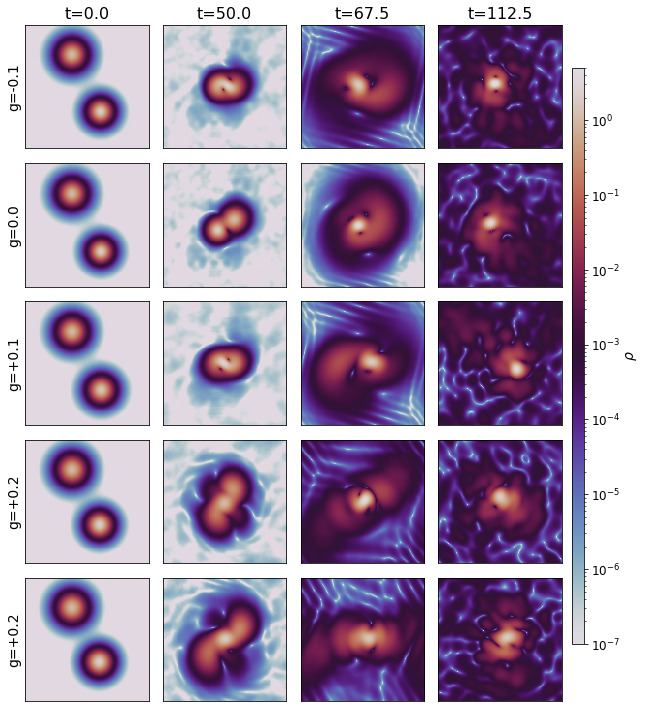

In [5]:
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle

plt.rcParams.update({
    'axes.titlesize': 16,     # Tamaño de la fuente del título del eje
    'axes.labelsize': 14,     # Tamaño de la fuente de las etiquetas de los ejes
    'xtick.labelsize': 12,    # Tamaño de la fuente de las etiquetas del eje x
    'ytick.labelsize': 12,    # Tamaño de la fuente de las etiquetas del eje y
    'legend.fontsize': 13,    # Tamaño de la fuente de la leyenda
    'figure.titlesize': 18    # Tamaño de la fuente del título de la figura
})

# Crear la figura y los ejes
fig, ax = plt.subplots(5,4, figsize=(8, 10))

vmin = 1.0e-7
vmax = 5.0

im = ax[0,0].imshow(rho_g01_0, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='twilight', norm=LogNorm(vmin=vmin, vmax=vmax), aspect='auto')
im = ax[0,1].imshow(rho_g01_1, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='twilight', norm=LogNorm(vmin=vmin, vmax=vmax), aspect='auto')
im = ax[0,2].imshow(rho_g01_2, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='twilight', norm=LogNorm(vmin=vmin, vmax=vmax), aspect='auto')
im = ax[0,3].imshow(rho_g01_3, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='twilight', norm=LogNorm(vmin=vmin, vmax=vmax), aspect='auto')

im = ax[1,0].imshow(rho_g00_0, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='twilight', norm=LogNorm(vmin=vmin, vmax=vmax), aspect='auto')
im = ax[1,1].imshow(rho_g00_1, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='twilight', norm=LogNorm(vmin=vmin, vmax=vmax), aspect='auto')
im = ax[1,2].imshow(rho_g00_2, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='twilight', norm=LogNorm(vmin=vmin, vmax=vmax), aspect='auto')
im = ax[1,3].imshow(rho_g00_3, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='twilight', norm=LogNorm(vmin=vmin, vmax=vmax), aspect='auto')

im = ax[2,0].imshow(rho_g03_0, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='twilight', norm=LogNorm(vmin=vmin, vmax=vmax), aspect='auto')
im = ax[2,1].imshow(rho_g03_1, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='twilight', norm=LogNorm(vmin=vmin, vmax=vmax), aspect='auto')
im = ax[2,2].imshow(rho_g03_2, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='twilight', norm=LogNorm(vmin=vmin, vmax=vmax), aspect='auto')
im = ax[2,3].imshow(rho_g03_3, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='twilight', norm=LogNorm(vmin=vmin, vmax=vmax), aspect='auto')

im = ax[3,0].imshow(rho_g04_0, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='twilight', norm=LogNorm(vmin=vmin, vmax=vmax), aspect='auto')
im = ax[3,1].imshow(rho_g04_1, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='twilight', norm=LogNorm(vmin=vmin, vmax=vmax), aspect='auto')
im = ax[3,2].imshow(rho_g04_2, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='twilight', norm=LogNorm(vmin=vmin, vmax=vmax), aspect='auto')
im = ax[3,3].imshow(rho_g04_3, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='twilight', norm=LogNorm(vmin=vmin, vmax=vmax), aspect='auto')


im = ax[4,0].imshow(rho_g05_0, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='twilight', norm=LogNorm(vmin=vmin, vmax=vmax), aspect='auto')
im = ax[4,1].imshow(rho_g05_1, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='twilight', norm=LogNorm(vmin=vmin, vmax=vmax), aspect='auto')
im = ax[4,2].imshow(rho_g05_2, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='twilight', norm=LogNorm(vmin=vmin, vmax=vmax), aspect='auto')
im = ax[4,3].imshow(rho_g05_3, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='twilight', norm=LogNorm(vmin=vmin, vmax=vmax), aspect='auto')


for i in range(4):
    for j in range(5):
        ax[j,i].set_aspect('equal')
        ax[j,i].set_xticks([])
        ax[j,i].set_yticks([])


ax[0,0].set_ylabel(r'g=-0.1')
ax[1,0].set_ylabel(r'g=0.0')
ax[2,0].set_ylabel(r'g=+0.1')
ax[3,0].set_ylabel(r'g=+0.2')
ax[4,0].set_ylabel(r'g=+0.2')

ax[0,0].set_title(r't=' + str(t[0]))
ax[0,1].set_title(r't=' + str(t[20]))
ax[0,2].set_title(r't=' + str(t[27]))
ax[0,3].set_title(r't=' + str(t[45]))

# Añadir una barra de color para todas las subgráficas
cbar_ax = fig.add_axes([1.0, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, label=r'$\rho$')

fig.subplots_adjust(left=0.0, right=0.9, top=0.9, bottom=0.0, wspace=0.0, hspace=0.0)
# Ajustar el diseño
plt.tight_layout()
#plt.xlim([0.2, 0.7])
plt.savefig('density_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import imageio

# Configurar parámetros de matplotlib
plt.rcParams.update({
    'axes.titlesize': 16,     # Tamaño de la fuente del título del eje
    'axes.labelsize': 14,     # Tamaño de la fuente de las etiquetas de los ejes
    'xtick.labelsize': 12,    # Tamaño de la fuente de las etiquetas del eje x
    'ytick.labelsize': 12,    # Tamaño de la fuente de las etiquetas del eje y
    'legend.fontsize': 13,    # Tamaño de la fuente de la leyenda
    'figure.titlesize': 18    # Tamaño de la fuente del título de la figura
})

# Lista de arrays rho para las imágenes
vmin = 1.0e-7
vmax = 5.0

# Crear y guardar cada imagen
filenames = []
for i in range(100):

    x, y, z, rho_0 = readh5_2(path = '/media/ivan/TOSHIBA EXT/TENA/g01/rho.h5', index=i)
    x, y, z = np.meshgrid(x, y, z, indexing='ij')
    # Encuentra el índice correspondiente a z=0
    z_index = np.argmin(np.abs(z[0, 0, :]))
    # Extrae la sección rho en z=0
    rho_1 = rho_0[z_index, :, :]
    

    x, y, z, rho_0 = readh5_2(path = '/media/ivan/TOSHIBA EXT/TENA/g00/rho.h5', index=i)
    x, y, z = np.meshgrid(x, y, z, indexing='ij')
    # Encuentra el índice correspondiente a z=0
    z_index = np.argmin(np.abs(z[0, 0, :]))
    # Extrae la sección rho en z=0
    rho_2 = rho_0[z_index, :, :]
    

    x, y, z, rho_0 = readh5_2(path = '/media/ivan/TOSHIBA EXT/TENA/g03/rho.h5', index=i)
    x, y, z = np.meshgrid(x, y, z, indexing='ij')
    # Encuentra el índice correspondiente a z=0
    z_index = np.argmin(np.abs(z[0, 0, :]))
    # Extrae la sección rho en z=0
    rho_3 = rho_0[z_index, :, :]


    x, y, z, rho_0 = readh5_2(path = '/media/ivan/TOSHIBA EXT/TENA/g04/rho.h5', index=i)
    x, y, z = np.meshgrid(x, y, z, indexing='ij')
    # Encuentra el índice correspondiente a z=0
    z_index = np.argmin(np.abs(z[0, 0, :]))
    # Extrae la sección rho en z=0
    rho_4 = rho_0[z_index, :, :]

    x, y, z, rho_0 = readh5_2(path = '/media/ivan/TOSHIBA EXT/TENA/g05/rho.h5', index=i)
    x, y, z = np.meshgrid(x, y, z, indexing='ij')
    # Encuentra el índice correspondiente a z=0
    z_index = np.argmin(np.abs(z[0, 0, :]))
    # Extrae la sección rho en z=0
    rho_5 = rho_0[z_index, :, :]


    fig, ax = plt.subplots(1,5,figsize=(10, 8))
    im = ax[0].imshow(rho_1, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='twilight', norm=LogNorm(vmin=vmin, vmax=vmax), aspect='auto')
    im = ax[1].imshow(rho_2, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='twilight', norm=LogNorm(vmin=vmin, vmax=vmax), aspect='auto')
    im = ax[2].imshow(rho_3, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='twilight', norm=LogNorm(vmin=vmin, vmax=vmax), aspect='auto')
    im = ax[3].imshow(rho_4, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='twilight', norm=LogNorm(vmin=vmin, vmax=vmax), aspect='auto')
    im = ax[4].imshow(rho_5, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='twilight', norm=LogNorm(vmin=vmin, vmax=vmax), aspect='auto')
    
    for k in range(5):
        ax[k].set_aspect('equal')
        ax[k].set_xticks([])
        ax[k].set_yticks([])

    ax[0].set_title(r'$g=-0.1$')
    ax[1].set_title(r'$g=0.0$')
    ax[2].set_title(r'$g=+0.1$')
    ax[3].set_title(r'$g=+0.2$')
    ax[4].set_title(r'$g=+0.3$')

    # Añadir la barra de color
    #cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    #cbar.set_label(r'$\rho$')

    # Guardar la figura temporalmente
    filename = f'temp_{i}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    filenames.append(filename)
    plt.close(fig)

# Crear un GIF a partir de las imágenes guardadas
with imageio.get_writer('density_evolution.gif', mode='I', duration=0.5) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Eliminar los archivos temporales
import os
for filename in filenames:
    os.remove(filename)


<ipython-input-6-21a906b271d5>:94: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [4]:
data = np.loadtxt('g01/r.rho.asc')
r1 = data[:,0]
rho1 = data[:,1]

data = np.loadtxt('g00/r.rho.asc')
r2 = data[:,0]
rho2 = data[:,1]

data = np.loadtxt('g03/r.rho.asc')
r3 = data[:,0]
rho3 = data[:,1]

data = np.loadtxt('g04/r.rho.asc')
r4 = data[:,0]
rho4 = data[:,1]

data = np.loadtxt('g05/r.rho.asc')
r5 = data[:,0]
rho5 = data[:,1]

N1 = len(r1) // 500

t1 = np.linspace(0.0, 250.0, N1)
r1 = r1.reshape(N1, 500)
rho1 = rho1.reshape(N1, 500)

N2 = len(r2) // 500

r2 = r2.reshape(N2, 500)
rho2 = rho2.reshape(N2, 500)

N3 = len(r3) // 500

t3 = np.linspace(0.0, 250.0, N3)
r3 = r3.reshape(N3, 500)
rho3 = rho3.reshape(N3, 500)

N4 = len(r4) // 500

t4 = np.linspace(0.0, 250.0, N4)
r4 = r4.reshape(N4, 500)
rho4 = rho4.reshape(N4, 500)

N5 = len(r5) // 500

t5 = np.linspace(0.0, 250.0, N5)
r5 = r5.reshape(N5, 500)
rho5 = rho5.reshape(N5, 500)

r2 = r2[0:N2-1]
rho2 = rho2[0:N2-1]
N2 = len(r2)
t2 = np.linspace(0.0, 250.0, N2)

r3 = r3[0:N3-1]
rho3 = rho3[0:N3-1]
N3 = len(r3)
t3 = np.linspace(0.0, 250.0, N3)

r4 = r4[0:N4-1]
rho4 = rho4[0:N4-1]
N4 = len(r4)
t4 = np.linspace(0.0, 250.0, N4)

r5 = r5[0:N5-1]
rho5 = rho5[0:N5-1]
N5 = len(r5)
t5 = np.linspace(0.0, 250.0, N5)

In [5]:
def core(r, rhoc, g):
    alpha = g * np.sqrt(rhoc)
    a1 = 0.36810
    a2 = 0.09050
    b1 = 0.28420
    b2 = 0.08450
    b3 = -0.0117

    rc = 1.306 * rhoc**(-0.25) * (1.0 + a1 * alpha + a2 * alpha**2)
    beta = b1 * alpha + b2 * alpha**2 + b3 * np.abs(alpha)**0.5

    return rhoc * (1.0 + 0.091 * (r/rc)**(2+beta))**(-8)

In [9]:
from scipy.optimize import curve_fit


[rhoc_11], pcov = curve_fit(lambda r, rhoc: core(r, rhoc, g=-0.1), r1[N1-60,:], rho1[N1-60,:])
[rhoc_12], pcov = curve_fit(lambda r, rhoc: core(r, rhoc, g=-0.1), r1[N1-30,:], rho1[N1-30,:])
[rhoc_13], pcov = curve_fit(lambda r, rhoc: core(r, rhoc, g=-0.1), r1[N1-1 ,:], rho1[N1-1 ,:])

[rhoc_21], pcov = curve_fit(lambda r, rhoc: core(r, rhoc, g=0.0), r2[N2-60,:], rho2[N2-60,:])
[rhoc_22], pcov = curve_fit(lambda r, rhoc: core(r, rhoc, g=0.0), r2[N2-30,:], rho2[N2-30,:])
[rhoc_23], pcov = curve_fit(lambda r, rhoc: core(r, rhoc, g=0.0), r2[N2-1 ,:], rho2[N2-1 ,:])

[rhoc_31], pcov = curve_fit(lambda r, rhoc: core(r, rhoc, g=+0.1), r3[N3-60,:], rho3[N3-60,:])
[rhoc_32], pcov = curve_fit(lambda r, rhoc: core(r, rhoc, g=+0.1), r3[N3-30,:], rho3[N3-30,:])
[rhoc_33], pcov = curve_fit(lambda r, rhoc: core(r, rhoc, g=+0.1), r3[N3-1 ,:], rho3[N3-1 ,:])

[rhoc_41], pcov = curve_fit(lambda r, rhoc: core(r, rhoc, g=+0.2), r4[N4-60,:], rho4[N4-60,:])
[rhoc_42], pcov = curve_fit(lambda r, rhoc: core(r, rhoc, g=+0.2), r4[N4-30,:], rho4[N4-30,:])
[rhoc_43], pcov = curve_fit(lambda r, rhoc: core(r, rhoc, g=+0.2), r4[N4-1 ,:], rho4[N4-1 ,:])

[rhoc_51], pcov = curve_fit(lambda r, rhoc: core(r, rhoc, g=+0.2), r5[N5-60,:], rho5[N5-60,:])
[rhoc_52], pcov = curve_fit(lambda r, rhoc: core(r, rhoc, g=+0.2), r5[N5-30,:], rho5[N5-30,:])
[rhoc_53], pcov = curve_fit(lambda r, rhoc: core(r, rhoc, g=+0.2), r5[N5-1 ,:], rho5[N5-1 ,:])

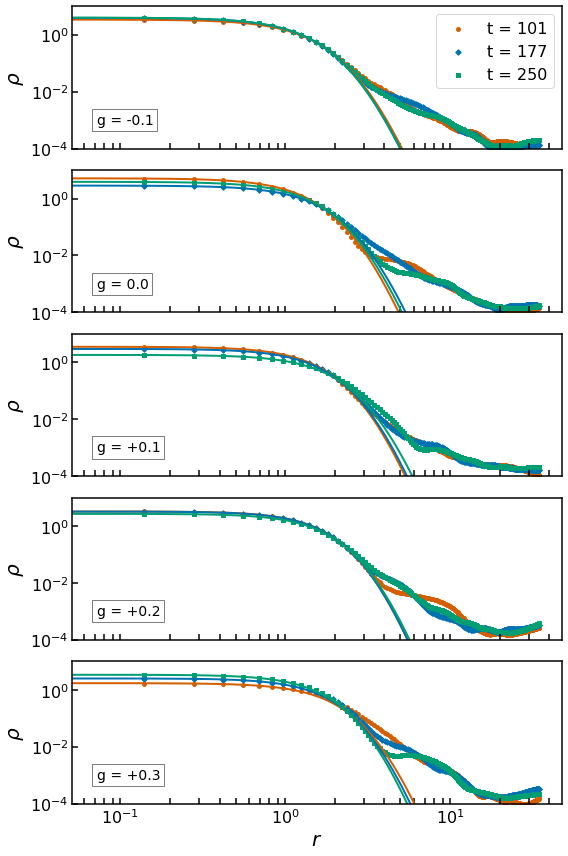

In [16]:
import matplotlib.pyplot as plt

# Configurar parámetros de matplotlib
plt.rcParams.update({
    'axes.titlesize': 20,
    'axes.labelsize': 10,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'figure.titlesize': 58,
    'axes.linewidth': 1.5,    # Grosor de los bordes de los ejes
    'xtick.major.width': 1.5, # Grosor de las marcas mayores en el eje x
    'ytick.major.width': 1.5, # Grosor de las marcas mayores en el eje y
    'xtick.minor.width': 1.0, # Grosor de las marcas menores en el eje x
    'ytick.minor.width': 1.0  # Grosor de las marcas menores en el eje y
})

fig, ax = plt.subplots(5, 1, figsize=(8, 12), sharex=True)  # Aumentar la altura de la figura y compartir el eje x

# Paleta de colores más armónica
colors = ['#D55E00', '#0072B2', '#009E73']
s = 15
step = 2

# Subgráfico 1
ax[0].scatter(r1[N1-20, ::step], rho1[N1-60, ::step], color=colors[0], s=s, label=f't = {t1[N1-60]:.3g}', marker='o')
ax[0].scatter(r1[N1-20, ::step], rho1[N1-30, ::step], color=colors[1], s=s, label=f't = {t1[N1-30]:.3g}', marker='D')
ax[0].scatter(r1[N1-20, ::step], rho1[N1-1,  ::step], color=colors[2], s=s, label=f't = {t1[N1-1]:.3g}', marker='s')
ax[0].plot(r1[N1-60, :], core(r1[N1-60, :], rhoc=rhoc_11, g=-0.1), linestyle='-', color=colors[0], linewidth=2)
ax[0].plot(r1[N1-30, :], core(r1[N1-30, :], rhoc=rhoc_12, g=-0.1), linestyle='-', color=colors[1], linewidth=2)
ax[0].plot(r1[N1-1, :], core(r1[N1-1, :], rhoc=rhoc_13, g=-0.1), linestyle='-', color=colors[2], linewidth=2)
ax[0].text(0.05, 0.25, 'g = -0.1', transform=ax[0].transAxes, fontsize=14, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

# Subgráfico 2
ax[1].scatter(r2[N2-20, ::step], rho2[N2-60, ::step], color=colors[0], s=s, marker='o')
ax[1].scatter(r2[N2-20, ::step], rho2[N2-30, ::step], color=colors[1], s=s, marker='D')
ax[1].scatter(r2[N2-20, ::step], rho2[N2-1,  ::step], color=colors[2], s=s, marker='s')
ax[1].plot(r2[N2-60, :], core(r2[N2-60, :], rhoc=rhoc_21, g=0.0), linestyle='-', color=colors[0], linewidth=2)
ax[1].plot(r2[N2-30, :], core(r2[N2-30, :], rhoc=rhoc_22, g=0.0), linestyle='-', color=colors[1], linewidth=2)
ax[1].plot(r2[N2-1, :], core(r2[N2-1, :], rhoc=rhoc_23, g=0.0), linestyle='-', color=colors[2], linewidth=2)
ax[1].text(0.05, 0.25, 'g = 0.0', transform=ax[1].transAxes, fontsize=14, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

# Subgráfico 3
ax[2].scatter(r3[N3-20, ::step], rho3[N3-60, ::step], color=colors[0], s=s, marker='o')
ax[2].scatter(r3[N3-20, ::step], rho3[N3-30, ::step], color=colors[1], s=s, marker='D')
ax[2].scatter(r3[N3-20, ::step], rho3[N3-1,  ::step], color=colors[2], s=s, marker='s')
ax[2].plot(r3[N3-60, :], core(r3[N3-60, :], rhoc=rhoc_31, g=+0.1), linestyle='-', color=colors[0], linewidth=2)
ax[2].plot(r3[N3-30, :], core(r3[N3-30, :], rhoc=rhoc_32, g=+0.1), linestyle='-', color=colors[1], linewidth=2)
ax[2].plot(r3[N3-1, :], core(r3[N3-1, :], rhoc=rhoc_33, g=+0.1), linestyle='-', color=colors[2], linewidth=2)
ax[2].text(0.05, 0.25, 'g = +0.1', transform=ax[2].transAxes, fontsize=14, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

# Subgráfico 4
ax[3].scatter(r4[N4-20, ::step], rho4[N4-60, ::step], color=colors[0], s=s, marker='o')
ax[3].scatter(r4[N4-20, ::step], rho4[N4-30, ::step], color=colors[1], s=s, marker='D')
ax[3].scatter(r4[N4-20, ::step], rho4[N4-1,  ::step], color=colors[2], s=s, marker='s')
ax[3].plot(r4[N4-60, :], core(r4[N4-60, :], rhoc=rhoc_41, g=+0.2), linestyle='-', color=colors[0], linewidth=2)
ax[3].plot(r4[N4-30, :], core(r4[N4-30, :], rhoc=rhoc_42, g=+0.2), linestyle='-', color=colors[1], linewidth=2)
ax[3].plot(r4[N4-1, :], core(r4[N4-1, :], rhoc=rhoc_43, g=+0.2), linestyle='-', color=colors[2], linewidth=2)
ax[3].text(0.05, 0.25, 'g = +0.2', transform=ax[3].transAxes, fontsize=14, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

# Subgráfico 5
ax[4].scatter(r5[N5-20, ::step], rho5[N5-60, ::step], color=colors[0], s=s, marker='o')
ax[4].scatter(r5[N5-20, ::step], rho5[N5-30, ::step], color=colors[1], s=s, marker='D')
ax[4].scatter(r5[N5-20, ::step], rho5[N5-1,  ::step], color=colors[2], s=s, marker='s')
ax[4].plot(r5[N5-60, :], core(r5[N5-60, :], rhoc=rhoc_51, g=+0.2), linestyle='-', color=colors[0], linewidth=2)
ax[4].plot(r5[N5-30, :], core(r5[N5-30, :], rhoc=rhoc_52, g=+0.2), linestyle='-', color=colors[1], linewidth=2)
ax[4].plot(r5[N5-1, :], core(r5[N5-1, :], rhoc=rhoc_53, g=+0.2), linestyle='-', color=colors[2], linewidth=2)
ax[4].text(0.05, 0.25, 'g = +0.3', transform=ax[4].transAxes, fontsize=14, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

# Ajustes de los ejes
for j in range(len(ax)):
    ax[j].set_xscale('log')
    ax[j].set_yscale('log')
    ax[j].set_ylabel(r'$\rho$', fontsize=20)
    ax[j].tick_params(axis='both', which='both', direction='in', length=6, width=1.5)  # Marcas hacia dentro y más visibles
    ax[j].set_ylim([1.0e-4,10])

# Ajustar el último subgráfico
ax[4].set_xlabel(r'$r$', fontsize=20)

# Leyenda en el primer subgráfico
ax[0].legend()

# Ajustar los márgenes entre subgráficos
plt.subplots_adjust(hspace=0)  # Reduce el espacio vertical entre subgráficos

# Ajustar los márgenes entre subgráficos
fig.tight_layout()

# Guardar figura
plt.savefig('avg_fit.png', dpi=300, bbox_inches='tight')

# Mostrar la gráfica
plt.show()
